<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb4_train_segmentation_model_on_synthetic_images.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 4:</small><br/>Training a Model on Synthetic Images</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    We presented how computer graphics can be applied to the generation of <strong>synthetic images</strong> from 3D models. In this notebook, we will demonstrate how synthetic dataset can be used to train computer vision models, when real images are not available.<br/><br/>
    As an example, we will train another instance of our <em>FCN</em> model applied to the semantic segmentation of urban scenes (c.f. Notebook <a href="../Chapter06/ch6_nb5_build_and_train_a_fcn8s_semantic_segmentation_model_for_smart_cars.ipynb">6-5</a>). We will assume we do not have access to real training images (no <em>Cityscapes</em> training data), and instead use a famous dataset of synthetic urban images: <em><strong>SYNTHIA</strong></em>.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Preparing the Data

As usual, we first set up the input pipelines, both for training and for testing.

### Setting Up the Test Input Pipeline (*Cityscapes*)

We assume our readers are by now familiar with the *Cityscapes* dataset[$^1$](#ref), and how to pre-process its content. We will once again reuse the utility methods defined in Notebook [6-4](../Chapter06/ch6_nb4_data_preparation_for_smart_car_apps.ipynb).

This time however, we will only fetch and prepare the *Cityscapes* validation dataset, assuming (for the  sake of our demonstration) that the training one is not available.

In [9]:
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, get_cityscapes_file_pairs,
    cityscapes_input_fn, segmentation_input_fn, postprocess_to_show)

In [10]:
# Key variables:
batch_size     = 16
num_epochs     = 90
image_size     = [512, 512]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
random_seed    = 1
num_show       = 3

In [11]:
import math

num_val_imgs = len(get_cityscapes_file_pairs(split='val', 
                                             root_folder=CITYSCAPES_FOLDER)[0])
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=1, augment=False, seed=random_seed)

# For visualization purpose, we also create a validation dataset using the images 
# with blurred faces/immatriculation plates (for privacy). As we will just use 
# 2-3 images, we only create the `tf.data.Dataset` to grab one batch:
visual_val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=num_show,
    shuffle=True, num_epochs=1, augment=False, seed=random_seed, blurred=True)

val_image_samples, val_gt_samples = next(visual_val_dataset.__iter__())
del visual_val_dataset

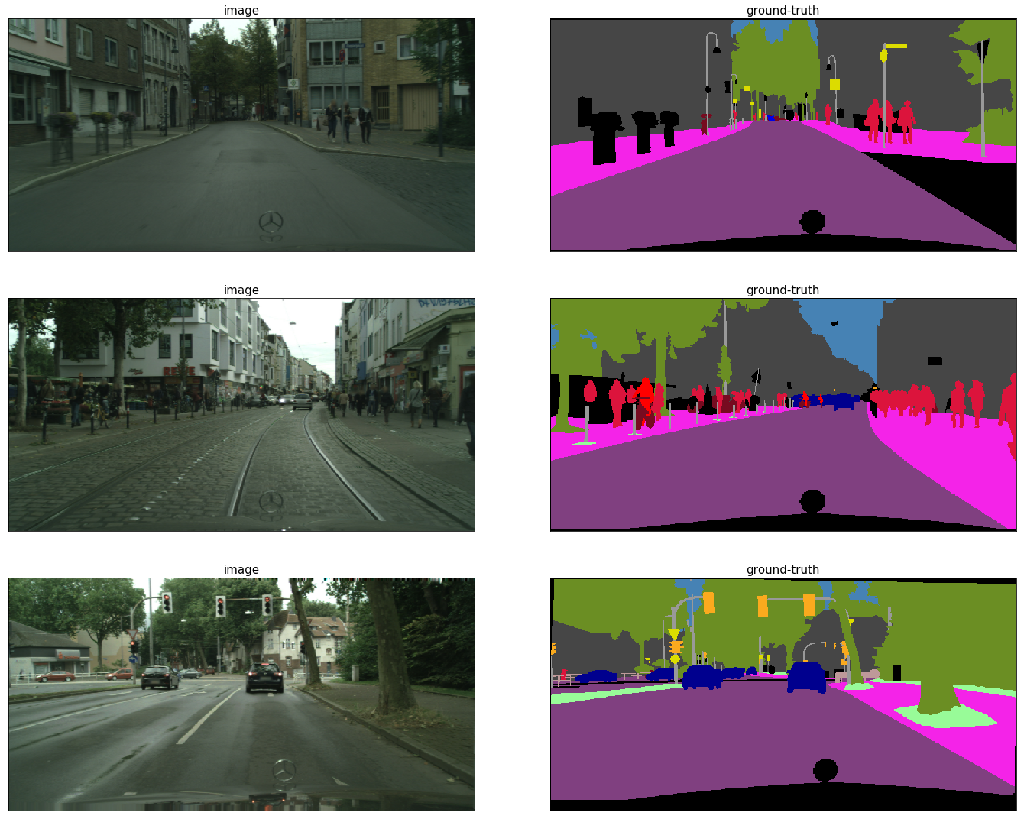

In [13]:
import matplotlib.pyplot as plt
from plot_utils import plot_image_grid

image_show, gt_show = postprocess_to_show(val_image_samples, val_gt_samples)  
figure = plot_image_grid([image_show, gt_show], 
                         ["image", "ground-truth"])
figure.show()

### Setting Up the Training Input Pipeline (*SYNTHIA*)

If one could not collect relevant training images, then using synthetic data is often the go-to solution. As a result, a lot of synthetic datasets have been proposed by experts. These datasets usually contain 3D models for people to render their own images, and/or pre-rendered images with their annotations. The *SYNTHIA* dataset[$^2$](#ref) falls into the latter category.

Based on a urban simulation tool proposed by Ros et al., *SYNTHIA* is composed of multiple sequences of urban images, with dense annotations. The data is freely available on the project's website: [http://synthia-dataset.net/download-2](http://synthia-dataset.net/download-2).

We invite our readers to check this website and download a couple of sequences, such as the "_SYNTHIA-RAND-CITYSCAPES_" or "_SEQS-04 (Old European Town)_ - Fall" ones (which are the closest in terms of content to *Cityscapes*). Once the data downloaded and unzipped, we define an environment variable lonking to the dataset's folder:

In [1]:
!export SYNTHIA_DATASET="/path/to/datasets/synthia"

Time now to set up the input pipeline for this dataset. We simply adapt the *Cityscapes* function to the slightly different structure of *SYNTHIA*:

In [14]:
import glob

SYNTHIA_FOLDER = os.getenv('SYNTHIA_DATASET', default=os.path.expanduser('~/datasets/synthia'))  
SYNTHIA_FILE_TEMPLATE = os.path.join(
    '{root}', '{seq}', '{type}', '{type2}', '{direction}', '{frame:{filler}>{len_fill}}{ext}')

def get_synthia_file_pairs(sequence='*', frame='*', ext='.png', 
                           direction='*', type2='*', gt_type='LABELS',
                           root_folder=SYNTHIA_FOLDER, file_template=SYNTHIA_FILE_TEMPLATE):
    """
    Fetch pairs of filenames for the Synthia dataset.
    Note: wildcards accepted for the parameters (e.g. city='*' to return image pairs from every city)
    :param sequence:        Name of the sequence(s)
    :param frame:           Name of the frame
    :param ext:             File extension
    :param direction:       Camera side ("Omni_F" for face, "Omni_B" for back, "Omni_L" for left, ...)
    :param type2:           'Stereo_Left' or 'Stereo_Right'
    :param gt_type:         Type of GT ("COLORS" or "LABELS" by default)
    :param root_folder:     Synthia root folder
    :param file_template:   File template to be applied (default corresponds to Synthia original format)
    :return:                List of input files, List of corresponding GT files
    """
    input_file_template = file_template.format(
        root=root_folder, type='RGB', type2=type2, direction=direction,
        len_fill=1, filler='*',  seq=sequence, frame=frame, ext=ext)
    input_files = glob.glob(input_file_template)
    
    gt_file_template = file_template.format(
        root=root_folder, type=os.path.join('GT', gt_type), type2=type2, direction=direction,
        len_fill=1, filler='*',  seq=sequence, frame=frame, ext=ext)
    gt_files = glob.glob(gt_file_template)
    
    assert(len(input_files) == len(gt_files))
    return sorted(input_files), sorted(gt_files)

In [15]:
synthia_train_input_files, synthia_train_gt_files = get_synthia_file_pairs()
num_synthia_train_imgs = len(synthia_train_input_files)

val_input_files, val_gt_files = get_cityscapes_file_pairs(split='val')
print("Synthia - Training Dataset : {} image/GT pairs.".format(num_synthia_train_imgs))

Synthia - Training Dataset : 7288 image/GT pairs.


One problem, though, is that the *SYNTHIA* authors opted for an labeling format different from the one used by *Cityscapes* authors. The label images are stored in a different format, and the values do not correspond to the same classes. Therefore, we define below a mapping and parsing function to convert the *SYNTHIA* labels to the  *Cityscapes* format, in order to homogenize and simplify the data processing later. The converted labels are thus saved and stored.

***Note:*** Moreover, different values/classes are used in some *SYNTHIA* sequences, such as "_SYNTHIA-RAND-CITYSCAPES_". If you opted for this sequence, please use a different mapping to convert to *Cityscapes* format. This mapping (`SYNTHIA_RAND_CS_2_CITYSCAPES_MAPPING`) is provided in [`synthia_utils.py`](./synthia_utils.py).

In [16]:
# Alas, Synthia GT images are saved in a non-standard format. As far as we tried,
# only OpenCV manages to read them properly...

# !pip install opencv-python # <-- uncomment to install skimage with pip
import cv2 
import warnings

SYNTHIA_2_CITYSCAPES_MAPPING = [
    [ 0, 255], # void
    [ 1,  10], # sky
    [ 2,   2], # building
    [ 3,   0], # road
    [ 4,   1], # sidewalk
    [ 5,   4], # fence
    [ 6,   8], # vegetation
    [ 7,   5], # pole
    [ 8,  13], # car
    [ 9,   7], # traffic sign
    [10,  11], # pedestrian/person
    [11,  18], # bicycle
    [12,   0], # linemarking/road
    [13, 255], # reserved
    [14, 255], # reserved
    [15,   6]  # traffic light
               # other Cityscapes classes are missing from Synthia (rider,truck, ...)
]

def convert_synthia_labels_to_cityscapes_format(gt_files, 
                                                gt_label_folder=os.path.join('GT','LABEL_CS')):
    
    for gt_file in gt_files:
        gt = cv2.imread(gt_file, cv2.IMREAD_UNCHANGED)
        # Keep only the last channel (1st is unsused, 2nd is for instance segmentation):
        gt = gt[..., 2]
        # Map Synthia class values to Cityscapes ones:
        gt_cs = np.copy(gt)
        for i in range(len(SYNTHIA_2_CITYSCAPES_MAPPING)):
            # Get mask:
            mask = gt==SYNTHIA_2_CITYSCAPES_MAPPING[i][0]
            # Replace:
            gt_cs[mask] = SYNTHIA_2_CITYSCAPES_MAPPING[i][1]
        gt_cs_file = gt_file.replace(os.path.join('GT','LABELS'), gt_label_folder)
        gt_cs_dir = os.path.dirname(gt_cs_file)
        if not os.path.exists(gt_cs_dir):
            os.makedirs(gt_cs_dir)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # to ignore skimage's warnings.
            io.imsave(gt_cs_file, gt_cs, check_contrast=False)
    return

In [20]:
# In case this notebooks is run several, we make sure not to repeat this operation:
synthia_sequence = synthia_train_gt_files[0].split(SYNTHIA_FOLDER)[1].split(os.sep)[1]
gt_cs_path = os.path.join(SYNTHIA_FOLDER, synthia_sequence, 'GT','LABEL_CS')
if not os.path.exists(gt_cs_path):
    print("GT conversion: start.")
    convert_synthia_labels_to_cityscapes_format(synthia_train_gt_files)
    print("GT conversion: stop.")
else:
    print("GT conversion: done already.")

GT conversion: done already.


Having adapted the training dataset to match the *Cityscapes* format, we can, therefore, re-use the same functions to set up the training input pipeline:

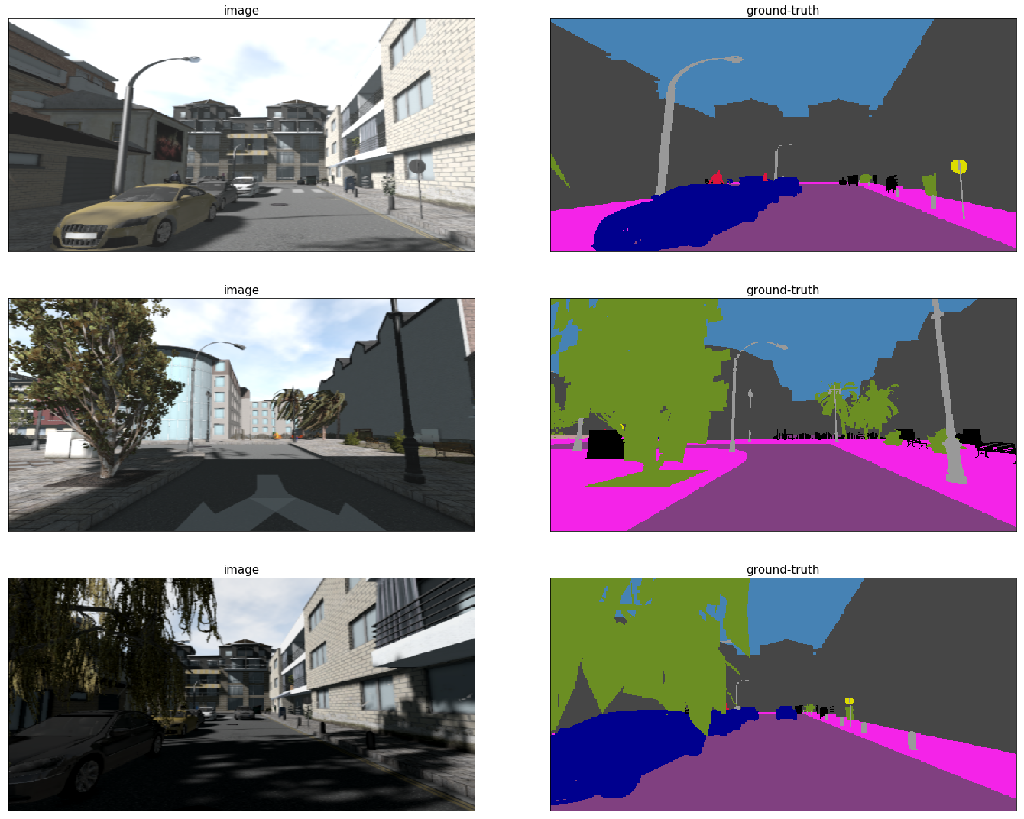

In [30]:
synthia_train_input_files, synthia_train_gt_files = get_synthia_file_pairs(gt_type='LABEL_CS')
train_steps_per_epoch = math.ceil(len(synthia_train_input_files) / batch_size)

synthia_train_dataset = segmentation_input_fn(
    synthia_train_input_files, synthia_train_gt_files, 
    resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)

train_image_samples, train_gt_samples = next(synthia_train_dataset.__iter__())
train_image_samples, train_gt_samples = train_image_samples[:num_show], train_gt_samples[:num_show]
image_show, gt_show = postprocess_to_show(train_image_samples, train_gt_samples)  
figure = plot_image_grid([image_show, gt_show], 
                         ["image", "ground-truth"])
figure.show()

As we can see, *SYNTHIA* contains images of urban scenes, trying to mimic real data. Still, we can observe some differences with real pictures (less noise, simpler textures, etc.). Let's see how it affects our recognition model.

## Training a FCN-8s Model for Semantic Segmentation on Synthetic Data

In Chapter 6, we presented the **_FCN_ architectures**[$^3$](#ref), and we implemented and trained our own version in Notebook [6-5](../Chapter06/ch6_nb5_build_and_train_a_fcn8s_semantic_segmentation_model_for_smart_cars.ipynb) to perform semantic segmentation.

We will reuse this previous implementation, this time training it on synthetic images. The procedure is highly similar to the semantic segmentation training presented in the previous chapter and its notebooks:

In [31]:
from fcn import fcn_8s

fcn8s_model = fcn_8s(image_size, num_channels, num_classes)

In [38]:
from tf_losses_and_metrics import (
    WeightedSegmentationLoss, SegmentationAccuracy, SegmentationMeanIoU)

optimizer = tf.keras.optimizers.Adam()

# Class weights computed in previous chapter:
cityscapes_class_weights = [0.95, 2.84, 1.53, 5.07, 4.74, 4.38, 6.18, 5.19, 1.86, 
                            4.48, 3.37, 4.31, 6.48, 2.64, 5.86, 5.97, 5.98, 6.86, 5.45]
cityscapes_class_weights = tf.constant(cityscapes_class_weights)

fcn8s_model.compile(
    optimizer=optimizer, 
    loss=WeightedSegmentationLoss(from_logits=True, weights=cityscapes_class_weights), 
    metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])

In [39]:
import collections
from keras_custom_callbacks import SimpleLogCallback, TensorBoardImageGridCallback

model_name = 'cityscapes_fcn8s_trained_on_synthia'
model_dir = os.path.join('models', model_name)

def postprocess_for_grid_callback(input_images, predicted_images, gt_images):
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted_images = tf.math.argmax(predicted_images, axis=-1)
    predicted_images = tf.expand_dims(predicted_images, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        input_images, predicted_images, gt_images, one_hot=True)

    return images_show, predicted_show, gt_show

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, 
    input_images=val_image_samples, target_images=val_gt_samples, 
    preprocess_fn=postprocess_for_grid_callback,
    tag=model_name + '_results', figsize=(15, 15))

# Callback to simply log metrics at the end of each epoch (saving space caompared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("acc", "acc"), ("v-acc", "val_acc"),
                                            ("mIoU", "mIoU"), ("v-mIoU", "val_mIoU")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

<Figure size 4500x4500 with 0 Axes>

***Note:*** As mentioned in previous notebooks, this training is compute-heavy (large model and dataset). Make sure the procedure is performed on GPU(s) -- refer to Chapter 2 for alternatives.

In [40]:
callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    callback_tb_grid
]

history = fcn8s_model.fit(
    synthia_train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/90: loss = 0.605; v-loss = 8.327; acc = 0.910; v-acc = 0.368; mIoU = 0.531; v-mIoU = 0.083
Epoch  1/90: loss = 0.503; v-loss = 7.513; acc = 0.923; v-acc = 0.404; mIoU = 0.371; v-mIoU = 0.084
Epoch  2/90: loss = 0.427; v-loss = 6.657; acc = 0.934; v-acc = 0.493; mIoU = 0.421; v-mIoU = 0.111
Epoch  3/90: loss = 0.361; v-loss = 9.229; acc = 0.942; v-acc = 0.402; mIoU = 0.620; v-mIoU = 0.089
Epoch  4/90: loss = 0.342; v-loss = 6.701; acc = 0.945; v-acc = 0.443; mIoU = 0.589; v-mIoU = 0.105
Epoch  5/90: loss = 1.196; v-loss = 9.309; acc = 0.804; v-acc = 0.341; mIoU = 0.244; v-mIoU = 0.071
Epoch  6/90: loss = 0.709; v-loss = 9.362; acc = 0.892; v-acc = 0.376; mIoU = 0.312; v-mIoU = 0.084
Epoch  7/90: loss = 0.473; v-loss = 12.216; acc = 0.927; v-acc = 0.337; mIoU = 0.383; v-mIoU = 0.066
Epoch  8/90: loss = 0.402; v-loss = 14.933; acc = 0.937; v-acc = 0.388; mIoU = 0.412; v-mIoU = 0.079
Epoch  9/90: loss = 0.349; v-loss = 11.403; acc = 0.943; v-acc = 0.411; mIoU = 0.

The training was stopped early, as the validation metrics did not seem to be improving, alas. As we can see, while the model performs really well on the training data (c.f. accuracy and mIoU metrics), the results on the validation dataset do not look so good...

Let us have a look at qualitative results. First, on the synthetic training images:

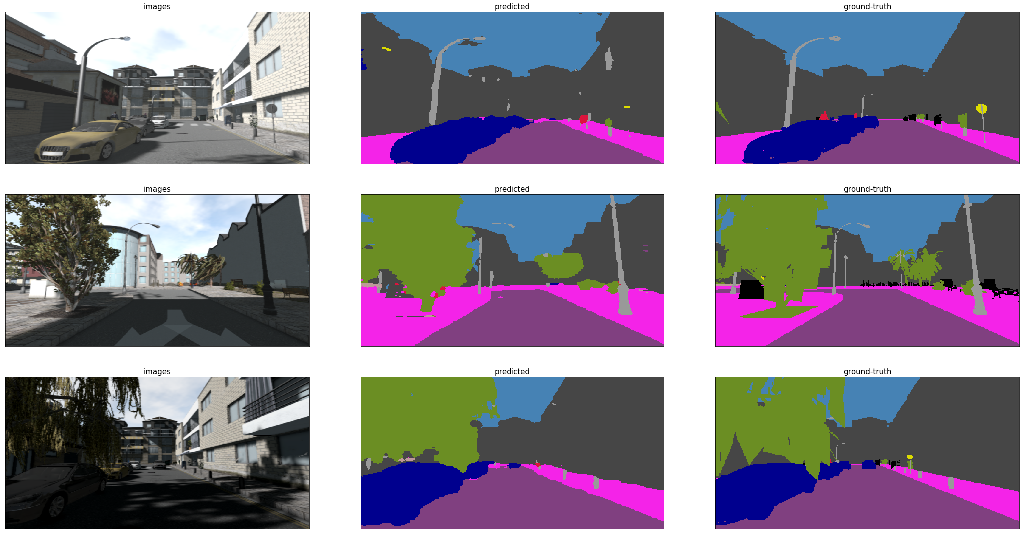

In [41]:
train_pred_samples = fcn8s_model.predict(train_image_samples)

image_show, predicted_show, gt_show = postprocess_for_grid_callback(
    train_image_samples, train_pred_samples, train_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

... and then on some real test images:

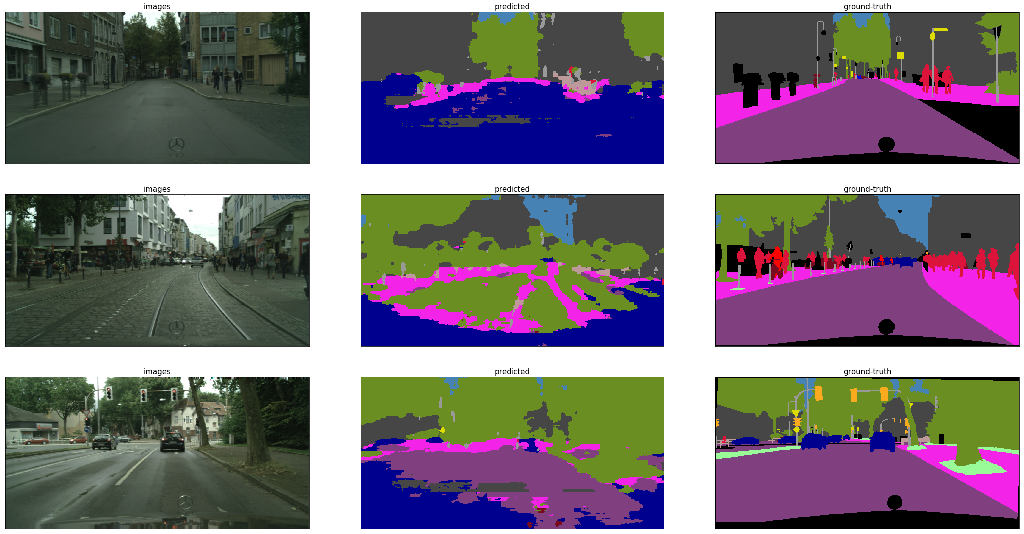

In [42]:
val_pred_samples = fcn8s_model.predict(val_image_samples)

image_show, predicted_show, gt_show = postprocess_for_grid_callback(
    val_image_samples, val_pred_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()

As we can see, the models gets confused by the discrepancies between synthetic and real images. It cannot properly rely on the features it has learned to extract, mistaking classes. 

## Conclusion

While the results do not match the quality we obtained when training on real data, it is worth highlighting that the usage of synthetic data still enabled us to train a coarse model despite the complete lack of relevant images. Furthermore, the task we chose as example here is a really complex one, and the discrepancies between the real target images and the synthetic source ones cannot be ignored (in terms of image quality, but also in terms of labels -- some *Cityscapes* classes do not appear in *SYNTHIA*).

For some applications, the gap between real and synthetic data can be much smaller, and machine learning models can properly benefit from the large quantity of images one can render. Nevertheless, solutions exist to partially bridge the *realism gap*. This will be the topic of the next notebook.

<a id="ref"></a>
#### References

1. Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., Franke, U., Roth, S., Schiele, B., 2016. The Cityscapes Dataset for Semantic Urban Scene Understanding. In: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Presented at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, Las Vegas, NV, USA, pp. 3213–3223.
2. Ros, G., Sellart, L., Materzynska, J., Vazquez, D. and Lopez, A.M., 2016. The synthia dataset: A large collection of synthetic images for semantic segmentation of urban scenes. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 3234-3243).
3. Shelhamer, E., Long, J., Darrell, T., 2017. Fully Convolutional Networks for Semantic Segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence 39, 640–651.